# Module 4: Anomaly Detection
## Practice: Outlier Reduction for Linear Regression
In this session, we'll be fitting a `LinearRegression` model on the `boston` dataset included in `scikit-learn`.  

Having already worked with this dataset,
you may remember it as a simple yet broadly representative linear regression problem.


## Getting started - imports

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, train_test_split

## Loading dataset

First order of business is to load in the dataset.  
Run the following cell to load the boston dataset and get a description of it.

In [2]:
# Load boston housing dataset
boston = load_boston()
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### Some preparatory processing.

In [3]:
# Select out just a few of the features 
# NOX      nitric oxides concentration (parts per 10 million)
# AGE      proportion of owner-occupied units built prior to 1
# RAD      index of accessibility to radial highways
# PTRATIO  pupil-teacher ratio by town
# LSTAT    % lower status of the population
boston_X = boston.data[:,(4,6,8,10,12)]
boston_y = boston.target
dataset = pd.DataFrame(np.column_stack([boston_X, boston_y])).sample(frac=1).reset_index(drop = True)

# Here's how to do the same with pandas
# boston_X = pd.DataFrame(boston.data[:,(4,6,8,10,12)])
# boston_y = pd.DataFrame(boston.target)
# dataset = pd.concat([boston_X, boston_y], axis=1, join_axes=[boston_X.index]).sample(frac=1).reset_index(drop = True)

dataset.columns = ['NOX', 'AGE', 'RAD', 'PTRATIO', 'LSTAT', 'TARGET']
dataset.describe()

,NOX,AGE,RAD,PTRATIO,LSTAT,TARGET
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.554695,68.574901,9.549407,18.455534,12.653063,22.532806
std,0.115878,28.148861,8.707259,2.164946,7.141062,9.197104
min,0.385000,2.900000,1.000000,12.600000,1.730000,5.000000
25%,0.449000,45.025000,4.000000,17.400000,6.950000,17.025000
50%,0.538000,77.500000,5.000000,19.050000,11.360000,21.200000
75%,0.624000,94.075000,24.000000,20.200000,16.955000,25.000000
max,0.871000,100.000000,24.000000,22.000000,37.970000,50.000000


#### Pull columns from dataset into variables X (everything except TARGET) and y (TARGET).

In [4]:
# Split into X and y sets (use indices 4,6,8,10,12 for X)

# Complete code below this comment  (Question #P4001)
# ----------------------------------
X = np.array(dataset.iloc[:,:-1])
y = np.array(dataset.TARGET)

# Print out some basic shape data on the arrays
print("X, y shape:", X.shape, y.shape)

X, y shape: (506, 5) (506,)


**Create training/validation split** with 30% data held out.

In [5]:
# Complete code below this comment  (Question #P4002)
# ----------------------------------
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3)

# verify split shapes and contents
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (354, 5)
y_train.shape:  (354,)
X_test.shape:  (152, 5)
y_test.shape:  (152,)


Run cross validation on a linear ridge model.

In [6]:
naive_model = Ridge()

# Complete code below this comment  (Question #P4003)
# ----------------------------------
scores = cross_val_score(naive_model,X_train,y_train,cv=3)
print("Scores: ", scores)
print("Mean score (3 folds): ", np.mean(scores))

Scores:  [ 0.63267399  0.66113187  0.59283608]
Mean score (3 folds):  0.628880647982


Fit this model on the training dataset.

In [7]:
# Complete code below this comment  (Question #P4004)
# ----------------------------------
naive_model.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Make some predictions from testing dataset and plot them.

(152, 5) (152,)


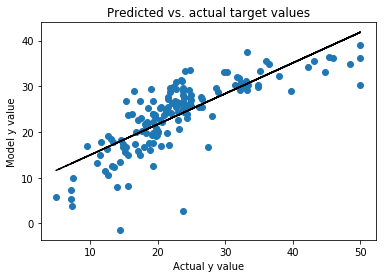

In [8]:
# Complete code below this comment  (Question #P4005)
# ----------------------------------
naive_predictions = naive_model.predict(X_test)
print(X_test.shape, naive_predictions.shape)
plt.scatter(y_test, naive_predictions)

# Fit a trendline for visualization
z = np.polyfit(y_test, naive_predictions, 1)
p = np.poly1d(z)
plt.title("Predicted vs. actual target values")
plt.xlabel("Actual y value")
plt.ylabel("Model y value")
plt.plot(y_test, p(y_test), 'k--')

## Issues with the above model
It is worth noting that without outlier reduction / anomaly detection in the pipeline, 
performance is relatively low. 
The actual performance on the test set is only scarcely better than random guessing 
(we can assume a baseline performance of 50% in such a case, and the model scores about 70%).

## Why a trendline?
This is mainly for illustrative purposes. 
The highest-error estimations are those farthest from the trendline, and ideally, 
the line of best fit would be `f(x) = x` 
(that is, the estimate and actual values would be perfectly equal in all cases).

## What methods are available to us for outlier reduction?
We could try `KMeans` or an `EllipticEnvelope` again, but we're going to explore a few more options. 

In [9]:
from sklearn.ensemble import IsolationForest

# Construct IsolationForest 
iso_forest = IsolationForest(n_estimators=250,
                             bootstrap=True).fit(X, y)

In [10]:
#help(IsolationForest)

Carefully read through the API documentation for Isolation Forest!

Pull **inliers** into variables X_iso and y_iso.

In [11]:
# Get labels from classifier and be ready to pull outliers
iso_outliers = iso_forest.predict(X)==-1

# Complete code below this comment  (Question #P4006)
# ----------------------------------
X_iso = X[~iso_outliers]
y_iso = y[~iso_outliers]

[ 0.67770207  0.59617724  0.60441213]
Mean CV score w/ IsolationForest: 0.626097146029


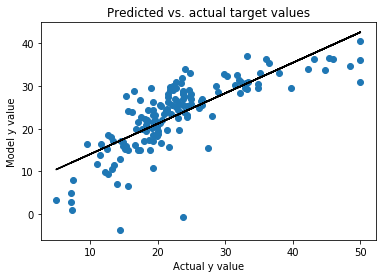

In [33]:
# We can of course run a train-test split on the separated data as well
X_train_iso, X_test_iso, y_train_iso, y_test_iso = train_test_split(X_iso, 
                                                                    y_iso, 
                                                                    test_size=0.3)
# Fit the new model using the IsolationForest training split
iso_model = Ridge()
iso_model.fit(X_train_iso, y_train_iso)

# Cross validate the new model
iso_scores = cross_val_score(estimator=iso_model, 
                             X=X_test_iso, y=y_test_iso)
print(iso_scores)
print("Mean CV score w/ IsolationForest:", np.mean(iso_scores))

iso_predictions = iso_model.predict(X_test)

# Plot the inlying points
plt.scatter(y_test, iso_predictions)

# Fit a trendline for visualization
z = np.polyfit(y_test, iso_predictions, 1)
p = np.poly1d(z)
plt.title("Predicted vs. actual target values")
plt.xlabel("Actual y value")
plt.ylabel("Model y value")
plt.plot(y_test, p(y_test), 'k-')

## Alternatives to IsolationForest: OneClassSVM
This means it's time to try something else.  
The code below will look very similar to the above, but using `OneClassSVM` in place of the `IsolationForest`:

In [13]:
from sklearn.svm import OneClassSVM

#help(OneClassSVM)

In [14]:
# Construct OneClassSVM (kernel='rbf') and fit to full dataset
svm = OneClassSVM(kernel='rbf').fit(X, y)

#### Mark outliers.
Pull **inliers** into variables X_svm and y_svm.

In [15]:
# Complete code below this comment  (Question #P4007)
# ----------------------------------

# Get labels from classifier and mark outliers
svm_outliers = svm.predict(X)==-1

# Pull inliers
X_svm = X[~svm_outliers]
y_svm = y[~svm_outliers]

[ 0.54990839  0.55281422  0.6549296 ]
Mean CV score w/ OneClassSVM: 0.58588407006


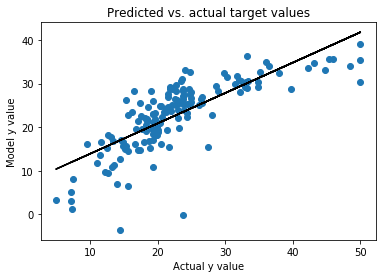

In [16]:
# Train-test split
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.3)

svm_model = Ridge().fit(X_train_svm, y_train_svm)

# Cross validate the new model
iso_scores = cross_val_score(estimator=svm_model, 
                             X=X_test_svm, y=y_test_svm)
print(iso_scores)
print("Mean CV score w/ OneClassSVM:", np.mean(iso_scores))

# Make predictions with the fitted model
svm_predictions = svm_model.predict(X_test)

# Plot the inlying points
plt.scatter(y_test, svm_predictions)

# Fit a trendline for visualization
z = np.polyfit(y_test, svm_predictions, 1)
p = np.poly1d(z)
plt.title("Predicted vs. actual target values")
plt.xlabel("Actual y value")
plt.ylabel("Model y value")
plt.plot(y_test, p(y_test), 'k-')

## Summary Analysis

Of the anomaly detection algorithms used, 
which had the highest marginal performance? 
Consider computational cost, which ones seemd to run fast versus slow?

## Going further: performance analysis w/ `scikit` modules
Compute and display the following for the models produced by each anomaly detection method:
 1. Confusion Matrix
 1. Accuracy
 1. Precision
 1. $F_1$-Score

In [29]:
# Add your code for the above tasks here:   (Question #P4008)
#  Ridge
# ----------------------------------------
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
# cut the variables based on quartiles 
naive_predictions_qcut = pd.qcut(naive_predictions, q=4, labels=False)
y_test_qcut = pd.qcut(y_test, 4, labels=False)

# compute confusion matrix 
print(confusion_matrix(y_test_qcut, naive_predictions_qcut.astype('i4')))
precision_recall_fscore_support(y_test_qcut,naive_predictions_qcut,average='micro')


[[29  6  3  0]
 [ 6 24  7  1]
 [ 2  7 21 10]
 [ 1  1  7 27]]


(0.66447368421052633, 0.66447368421052633, 0.66447368421052633, None)

In [34]:
# Add your code for the above tasks here:   (Question #P4009)
#  IsolationForest
# ----------------------------------------
iso_predictions = iso_model.predict(X_test_iso)
iso_predictions_qcut = pd.qcut(iso_predictions,q=4,labels=False)
y_test_iso_qcut = pd.qcut(y_test_iso,4,labels=False)
# compute confusion matrix and store in confmatrix
print(confusion_matrix(y_test_iso_qcut, iso_predictions_qcut.astype('i4')))
precision_recall_fscore_support(y_test_iso_qcut,iso_predictions_qcut,average='micro')

[[29  5  1  0]
 [ 5 20  7  2]
 [ 1  8 19  7]
 [ 0  1  7 25]]


(0.67883211678832112, 0.67883211678832112, 0.67883211678832112, None)

In [37]:
# Add your code for the above tasks here:   (Question #P4010)
#  OneClassSVM
# ------------------------------------------------


# Make predictions with the fitted model
svm_predictions = iso_model.predict(X_test_svm)
svm_predictions_qcut = pd.qcut(svm_predictions,q=4,labels=False)
y_test_svm_qcut = pd.qcut(y_test_svm,4,labels=False)
# compute confusion matrix and store in confmatrix
print(confusion_matrix(y_test_svm_qcut, svm_predictions_qcut.astype('i4')))
precision_recall_fscore_support(y_test_svm_qcut,svm_predictions_qcut,average='micro')





[[18  2  2  0]
 [ 2 11  8  0]
 [ 1  5  9  6]
 [ 1  3  2 15]]


(0.62352941176470589, 0.62352941176470589, 0.62352941176470589, None)

# Save your notebook!